In [1]:
using Pkg
Pkg.activate("../QControl")

  Activating project at `~/Github/mit/QControl.jl/QControl`


# Imports

In [2]:
import QControl

In [3]:
QControl.greet()

Hello World wow!

In [4]:
using QuantumOptics
using PyPlot
using Altro
using ForwardDiff
using LinearAlgebra
using SparseArrays
using RobotDynamics
using TrajectoryOptimization
using StaticArrays
using ForwardDiff
using FiniteDiff
const TO = TrajectoryOptimization
const RD = RobotDynamics

RobotDynamics

# Optimal Control with Altro

In [6]:
RobotDynamics.@autodiff struct QuantumState <: RobotDynamics.ContinuousDynamics end
# TODO: store appropriate information in QuantumState, e.g. state size

function complex_to_real_isomorphism(M::Union{Matrix{ComplexF64}, SparseMatrixCSC{ComplexF64, Int64}})
    """
    M
    => 
    Mᵣ -Mᵢ
    Mᵢ  Mᵣ
    """
    n_rows, n_cols = size(M) 
    M_full = zeros(Float64, (n_rows*2,n_cols*2))
    M_full[1:n_rows,1:n_cols] = real(M)
    M_full[n_rows+1:end,1:n_cols] = imag(M)
    M_full[1:n_rows,n_cols+1:end] = -imag(M)
    M_full[n_rows+1:end,n_cols+1:end] = real(M)
    return M_full
end 

function real_to_complex_isomorphism(M_full::Matrix{Float64})
    """
    Mᵣ -Mᵢ
    Mᵢ  Mᵣ
    => 
    M
    """
    n_rows, n_cols = size(M_full)
    M = M_full[1:n_rows ÷ 2,1:n_cols ÷ 2] + im*M_full[n_rows ÷ 2+1:end, 1:n_cols ÷ 2]
    return M
end 

function im_times_isomorphism(M_full::Matrix{Float64})
    """
    i(Mᵣ + iMᵢ) -> -Mᵢ + iMᵣ
    

    im
    *
     Mᵣ -Mᵢ
     Mᵢ  Mᵣ
    => 
    -Mᵢ -Mᵣ
     Mᵣ -Mᵢ   
    """
    n_rows_full, n_cols_full = size(M_full)
    n_rows = n_rows_full ÷ 2
    n_cols = n_cols_full ÷ 2
    Mᵣ = M_full[1:n_rows,1:n_cols]
    Mᵢ = M_full[n_rows+1:end, 1:n_cols]
    
    M_im = zeros(Float64, (n_rows_full,n_cols_full))
    M_im[1:n_rows,1:n_cols] = -Mᵢ
    M_im[n_rows+1:end,1:n_cols] = Mᵣ
    M_im[1:n_rows,n_cols+1:end] = -Mᵣ
    M_im[n_rows+1:end,n_cols+1:end] = -Mᵢ
    return M_im
end

function conj_isomorphism(M_full::Matrix{Float64})
    """
    Mᵣ + iMᵢ -> Mᵣ + i (-Mᵢ)
    
    
     Mᵣ -Mᵢ
     Mᵢ  Mᵣ
    => 
     Mᵣ  Mᵢ
    -Mᵢ  Mᵣ 
    """
    n_rows_full, n_cols_full = size(M_full)
    n_rows = n_rows_full ÷ 2
    n_cols = n_cols_full ÷ 2
    Mᵣ = M_full[1:n_rows,1:n_cols]
    Mᵢ = M_full[n_rows+1:end, 1:n_cols]
    
    M_im = zeros(Float64, (n_rows_full,n_cols_full))
    M_im[1:n_rows,1:n_cols] = Mᵣ
    M_im[n_rows+1:end,1:n_cols] =  -Mᵢ
    M_im[1:n_rows,n_cols+1:end] =  Mᵢ
    M_im[n_rows+1:end,n_cols+1:end] = Mᵣ
    return M_im
end
    
function complex_to_real_isomorphism(v::Vector{ComplexF64})
    """
    v
    => 
    vᵣ
    vᵢ
    """
    n_rows = size(v)[1]
    v_full = zeros(Float64, (n_rows*2,))
    v_full[1:n_rows] = real(v)
    v_full[n_rows+1:end] = imag(v)
    return v_full
end 

function real_to_complex_isomorphism(v_full::Vector{Float64})
    """
    vᵣ
    vᵢ
    => 
    v
    """
    n_rows = size(v_full)[1]
    v = v_full[1:n_rows ÷ 2] + im*v_full[n_rows ÷ 2 + 1: end]
    return v
end 

function im_times_isomorphism(v_full::Vector{Float64})
    """
    i(vᵣ + ivᵢ) -> -vᵢ + ivᵣ
    
    im 
    *
     vᵣ
     vᵢ
    => 
    -vᵢ
     vᵣ
    """
    n_rows_full = size(v_full)[1]
    n_rows = n_rows_full ÷ 2
    vᵣ = v_full[1:n_rows]
    vᵢ = v_full[n_rows + 1: end]
    
    v_im = zeros(Float64, (n_rows_full,))
    v_im[1:n_rows] = -vᵢ
    v_im[n_rows+1:end] = vᵣ
    return v_im
end 

function conj_isomorphism(v_full::Vector{Float64})
    """
    vᵣ + ivᵢ -> vᵣ + i(-vᵢ)
    
     vᵣ
     vᵢ
    => 
     vᵣ
    -vᵢ
    """
    n_rows_full = size(v_full)[1]
    n_rows = n_rows_full ÷ 2
    vᵣ = v_full[1:n_rows]
    vᵢ = v_full[n_rows + 1: end]
    
    v_im = zeros(Float64, (n_rows_full,))
    v_im[1:n_rows] = vᵣ
    v_im[n_rows+1:end] = -vᵢ
    return v_im
end

function gen_LQR_params(bfull::Basis, H₀::Operator, Hcs::Vector{<:Operator}, ψi::Vector{<:Ket}, ψt::Vector{<:Ket})
    """
    
    Args:
        bfull: full basis
        H₀ (Operator)
        Hcs (Vector{Ket}): vector of control Hamiltonians 
        ψi (Vector): vector of initial states
        ψt (Vector): vector of target states
    """
    H₀_full = complex_to_real_isomorphism(H₀.data)
    Hcs_full = complex_to_real_isomorphism.(map(H -> H.data, Hcs))
    ψi_full = complex_to_real_isomorphism.(map(ψ -> ψ.data, ψi))
    ψt_full = complex_to_real_isomorphism.(map(ψ -> ψ.data, ψt))
     
    
    ψi_combined = reduce(vcat, ψi_full)
    ψt_combined = reduce(vcat, ψt_full)
    
    num_states = size(ψi_full)[1]
    state_size = size(ψi_full[1])[1]
    @assert size(ψi_full)[1] == size(ψt_full)[1]
    state_dim = num_states*state_size
    
    num_controls = size(Hcs_full)[1] 
    control_dim = 2*num_controls # Factor of 2 comes from complex -> real
    
    
    function dynamics_func(::QuantumState, x, u)
        ψ_full = map(i -> x[(i-1)*state_size + 1:i*state_size], 1:num_states)
        Ht_full = H₀_full
        for control_indx=1:num_controls
            uᵣ = u[control_indx]
            uᵢ = u[control_indx + num_controls]
            Ht_full += uᵣ*Hcs_full[control_indx] + uᵢ*im_times_isomorphism(Hcs_full[control_indx])
        end
        
        # TODO: density matrices, loss, etc
        dψ = zeros(Float64, (state_dim, ))
        for i=1:num_states
            dψ[(i-1)*state_size + 1:i*state_size] = - im_times_isomorphism(Ht_full*ψ_full[i]) # Schrödinger equation
        end
        return dψ
    end
    
    
    return state_dim, control_dim, dynamics_func, ψi_combined, ψt_combined
end

;

# Single Qubit System

In [7]:
bq_single = SpinBasis(1//2)
H₀_single = 2*π*5*sigmaz(bq_single)/2
Hcs_single = [sigmax(bq_single)/2]
ψi_single = [spinup(bq_single)]
ψt_single = [spindown(bq_single)]
;

In [8]:
RD.state_dim(::QuantumState), RD.control_dim(::QuantumState), dynamics_func, ψi_state, ψf_state = gen_LQR_params(bq_single, H₀_single, Hcs_single, ψi_single, ψt_single)
RD.dynamics(qs::QuantumState,x,u) = dynamics_func(qs::QuantumState,x,u)
;

In [37]:
model = QuantumState()
state_dim = RD.state_dim(model)
control_dim = RD.control_dim(model)

N = 101 # number of time steps
tf = 3.0 # total time
dt = tf / (N-1) # time step

n_op = sigmap(bq_single)*sigmam(bq_single)
Q = complex_to_real_isomorphism(n_op.data)
R = complex_to_real_isomorphism(reshape([1.0 + 0.0*im],(1,1)))
I_matrix = complex_to_real_isomorphism(one(bq_single).data .+ 0*im)
Qf = (I_matrix - ψf_state*transpose(conj_isomorphism(ψf_state)))

obj = LQRObjective(Q,R,Qf,ψf_state,N)

Objective

In [41]:
prob = Problem(model, obj, ψi_state, tf, xf=ψf_state, integration=RD.RK4(model)) # constraints=cons,
;

# Cavity-Qubit System Setup

In [ ]:
# Define bases for cavity (Fock) and atom (Spin-1/2)
const N_CAVITY = 10
const N_QUBIT = 2

bq = SpinBasis(1//2)
bc = FockBasis(N_CAVITY - 1)
bfull = bc ⊗ bq
DAC_time_resolution = 1 # ns


# constants (in GHz = cycles / ns)
α = .4
K = 1e-5
χ = 2e-3
D = 1e-3

# operators
a = destroy(bc) ⊗ one(bq)
σ⁻ = one(bc) ⊗ sigmam(bq) # up -> down, equivalent to creation op
ad = dagger(a)
σ⁺ = dagger(σ⁻)

# base hamiltonian
H₀ = (α/2) * σ⁻ * σ⁻ * σ⁺ * σ⁺
H₀ += (K/2) * ad * ad * a * a
H₀ += χ * ad * a * σ⁻ * σ⁺
H₀ *= 2*π
Hcs = [2*π*D*(σ⁺ + σ⁻), im*2*π*D*(σ⁺ + σ⁻), 2*π*D*(a+ad), im*2*π*(a - ad)];

# binomial code
binomial = Dict("z+" => normalize(fockstate(bc,0) + fockstate(bc,4)), "z-" => fockstate(bc, 2))

# states
ψi = [fockstate(bc, 0) ⊗ spinup(bq)]
ψt = [binomial["z+"] ⊗ spinup(bq)]

;

In [155]:
RD.state_dim(::QuantumState), RD.control_dim(::QuantumState), dynamics_func = gen_LQR_params(bfull, H₀, Hcs, ψi, ψt)
RD.dynamics(qs::QuantumState,x,u) = dynamics_func(qs::QuantumState,x,u)
;

In [151]:
# testing
# RD.dynamics(test_qs,ψi_combined,[1,1,1,1,1,1,1,1])
# @assert 0.0 == maximum(abs.(ψi[1].data - vector_real_to_complex_isomorphism(vector_complex_to_real_isomorphism(ψi[1].data))))
# @assert 0.0 == maximum(abs.(H₀.data - matrix_real_to_complex_isomorphism(matrix_complex_to_real_isomorphism(H₀.data))))

# Playground

In [ ]:
# Construct Hamiltonian
ψ₀ = fockstate(bc,0) ⊗ spinup(bq)
T = [0.0:0.01:1;];

In [9]:
tout, ψₜ = timeevolution.schroedinger(T, ψ₀, H) ;

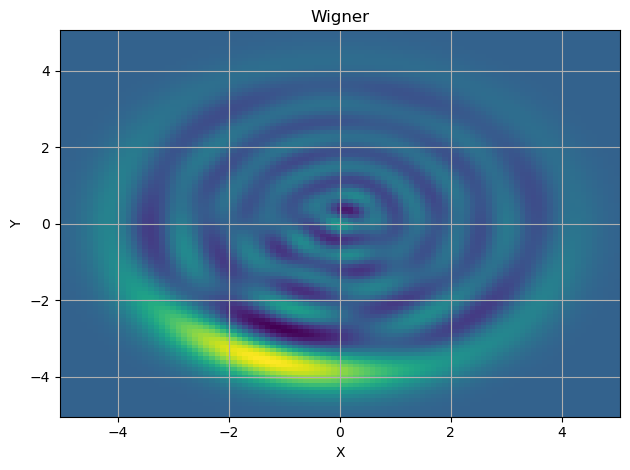

In [7]:
x = [-5:0.1:5;]
W = wigner(ptrace(ψ₁,2), x, x)
pcolor(x,x,W)
xlabel("X")
ylabel("Y")
title("Wigner")
grid("on")
tight_layout()

# References

[1] https://arxiv.org/pdf/1707.01060.pdf (quantum optics)

[2] https://github.com/alec-eickbusch/QOGS (quantum optimal gate synthesis)

[3] https://arxiv.org/pdf/2103.15716.pdf  (robotic quantum optimal control)

[4] https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031006 (binomial code)